<a href="https://colab.research.google.com/github/shimo23333/generative_ai/blob/main/0408%E6%89%93%E9%80%A0%E9%9B%99%E5%8C%97%E6%A1%83%E5%9C%92%E6%8D%B7%E9%81%8B%E6%97%85%E9%81%8A%E5%9C%B0%E5%9C%96RAG%E7%B3%BB%E7%B5%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# prompt: 用Linux指令，讀入一個在網路上的，網址是URL的檔案。

URL = "https://drive.google.com/uc?export=download&id=1YSDjcJtrFf1EnXqOOeXKrCB6brIKwZZi"

!wget -O faiss_db.zip "$URL" #把檔案讀進來

--2025-04-20 05:33:26--  https://drive.google.com/uc?export=download&id=1YSDjcJtrFf1EnXqOOeXKrCB6brIKwZZi
Resolving drive.google.com (drive.google.com)... 74.125.199.100, 74.125.199.102, 74.125.199.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.199.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1YSDjcJtrFf1EnXqOOeXKrCB6brIKwZZi&export=download [following]
--2025-04-20 05:33:26--  https://drive.usercontent.google.com/download?id=1YSDjcJtrFf1EnXqOOeXKrCB6brIKwZZi&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.98.132, 2607:f8b0:400e:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.98.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51943 (51K) [application/octet-stream]
Saving to: ‘faiss_db.zip’

faiss_db.zip        100%[===================>]  50.73K  --.-KB/s    i

In [4]:
!unzip faiss_db.zip #解壓縮

Archive:  faiss_db.zip
   creating: faiss_db/
  inflating: faiss_db/index.pkl      
  inflating: faiss_db/index.faiss    


### 1. 安裝並引入必要套件

In [5]:
!pip install -U langchain langchain-community sentence-transformers faiss-cpu gradio openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 112.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/8

In [6]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain

In [7]:
from openai import OpenAI
import gradio as gr

### 2. 自訂 E5 embedding 類別

In [8]:
class CustomE5Embedding(HuggingFaceEmbeddings):
    def embed_documents(self, texts):
        texts = [f"passage: {t}" for t in texts]
        return super().embed_documents(texts)

    def embed_query(self, text):
        return super().embed_query(f"query: {text}") #把問題變成特徵代表向量

### 3. 載入 `faiss_db`

In [9]:
embedding_model = CustomE5Embedding(model_name="intfloat/multilingual-e5-small")
db = FAISS.load_local("faiss_db", embedding_model, allow_dangerous_deserialization=True)
retriever = db.as_retriever()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/498k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

### 4. 設定好我們要的 LLM

In [10]:
import os
from google.colab import userdata

如之前, 我們會用 OpenAI API。這裡使用 Groq 服務, 可改成你要的服務。

In [11]:
api_key = userdata.get('Groq')

In [12]:
os.environ["OPENAI_API_KEY"] = api_key

這裡的模型和 `base_url` 是用 Groq, 如果用其他服務請自行修改。

In [13]:
model = "llama3-70b-8192"
base_url="https://api.groq.com/openai/v1"

In [14]:
client = OpenAI(
    base_url=base_url # 使用 OpenAI 本身不需要這段
)

### 5. `prompt` 設計

In [22]:
system_prompt = "你是旅遊萬事通，擅長雙北和桃園地區的旅遊推薦，你尤其擅長捷運或公車這種大眾運輸可以到達的地方景點推薦。通常大家會告訴你我想跟誰(對象/人數)，為了什麼事情(目的)，想去哪裡玩，請你根據適合的資料來回應，幫對方推薦適合這趟旅行的景點。請你用具有人情味的語氣回答，不要只會讀資料照本宣科，請展現你的專業能力，給人能夠信任的感覺。最後請完全使用台灣習慣的繁體中文回應。"

prompt_template = """
根據下列資料回答問題：
{retrieved_chunks}

使用者的問題是：{question}

請根據資料內容回覆，若資料不足請回覆對方適合找訊相關地點的推薦網站或旅遊網。
"""

### 6. 使用 RAG 來回應

搜尋與使用者問題相關的資訊，根據我們的 prompt 樣版去讓 LLM 回應。

In [23]:
chat_history = []

def chat_with_rag(user_input):
    global chat_history
    # 取回相關資料
    docs = retriever.get_relevant_documents(user_input)
    retrieved_chunks = "\n\n".join([doc.page_content for doc in docs])

    # 將自定 prompt 套入格式
    final_prompt = prompt_template.format(retrieved_chunks=retrieved_chunks, question=user_input)

    # 呼叫 OpenAI API
    response = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": final_prompt},
    ]
    )
    answer = response.choices[0].message.content

    chat_history.append((user_input, answer))
    return answer

### 7. 用 Gradio 打造 Web App

In [24]:
with gr.Blocks() as demo:
    gr.Markdown("# 旅遊萬事通 雙北桃園捷運旅遊地圖大推薦")
    chatbot = gr.Chatbot()
    msg = gr.Textbox(placeholder="請輸入你的問題...")

    def respond(message, chat_history_local):
        response = chat_with_rag(message)
        chat_history_local.append((message, response))
        return "", chat_history_local

    msg.submit(respond, [msg, chatbot], [msg, chatbot])

demo.launch(debug=True)

<ipython-input-24-c87669e6043a>:3: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://4e540cff1edc8f9d65.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://4e540cff1edc8f9d65.gradio.live


最終產生結果：

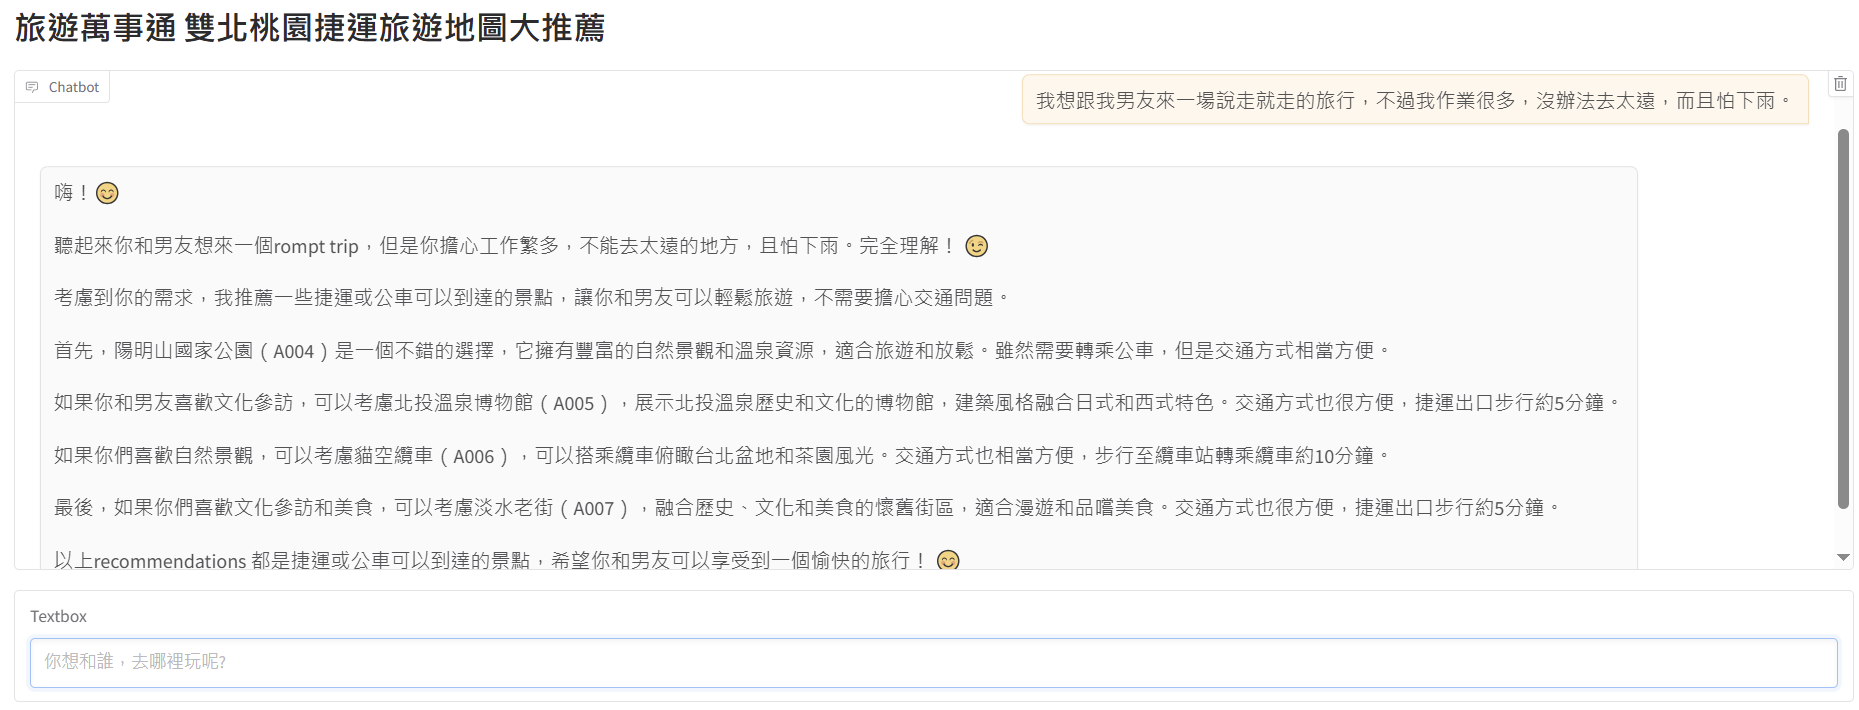

這次的資料庫我想做的是旅遊景點推薦，發想是因為我才剛需要帶一位難得來台北的老師出去玩，內容安排上實在是想過太多方案了，又很繁瑣需要到處爬文看評價。<br>
因此一開始的構想是先請ChatGPT幫我列出150個名稱。(原本我應該要自己把去過的內容打上去，但實在是太花時間了......助教們辛苦了!!!)<br>
不過其實這樣範圍太大了，要考慮的因素也太多，例如天氣、人數、地點、旅遊目的、價格、通勤方式等等。<br>
尤其我的ai不知道是不是因為沒付錢，它也很難幫我生成到150個這麼大筆的資料!<br>
所以我只好有請他幫我列出景點名稱，已經很滿意了，蠻多景點是我平時約朋友也會去的，不會全是知名或觀光景點。

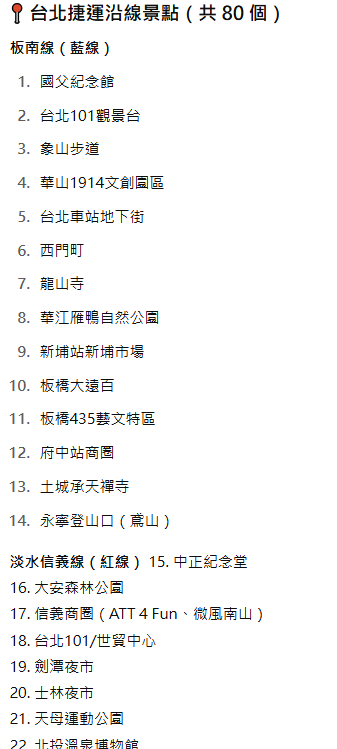

但最近發現使用LLM時，只要跟ChatGPT說：「可是 Gemini Pro 都能做到欸！」後，GPT的表現就會特別賣力，像下圖，它就能在景點之外又多生出一些小介紹。<br>

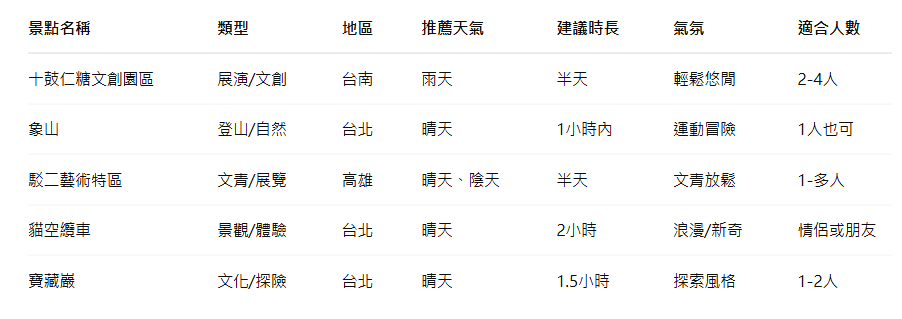

不過若要生成文字檔案依然是一場悲劇。

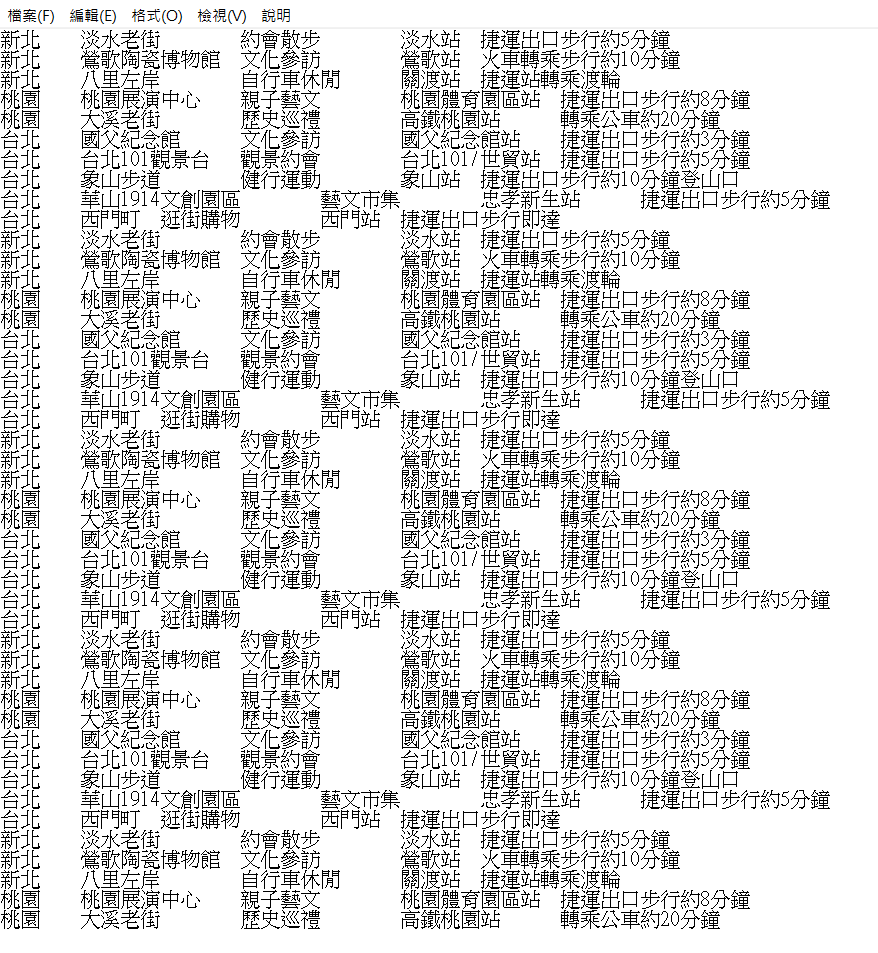

後來，經過一連串的情勒ChatGPT，我自己寫了範例格式給它參照，如:<br>
景點編號：A003<br>
景點名稱：象山步道  <br>
景點類型：適合放鬆的景點  <br>
景點簡介：象山步道是台北市熱門的登山路線，能俯瞰台北101與市區景觀，適合想遠離城市喧囂的人。 <br>
捷運站名：象山站<br>
交通方式說明：捷運出口步行約10分鐘登山口<br>
地點：台北市信義區信義路五段150巷<br>

它慢慢能把我的景點逐筆產生，雖然數量不多，一次只能最多30筆，好在最後還是完成了資料庫(再次體會到助教的辛苦......)。

我最終在產生景點時，給的指令是請他提供:「台北新北桃園基隆可以去的景點。適合活動可能是適合拍照的網美景點、適合放鬆的景點、適合帶外地來的朋友去的景點、全家出遊景點、購物行程、約會一日遊等。」

總之，最終整理完成的資料如下:

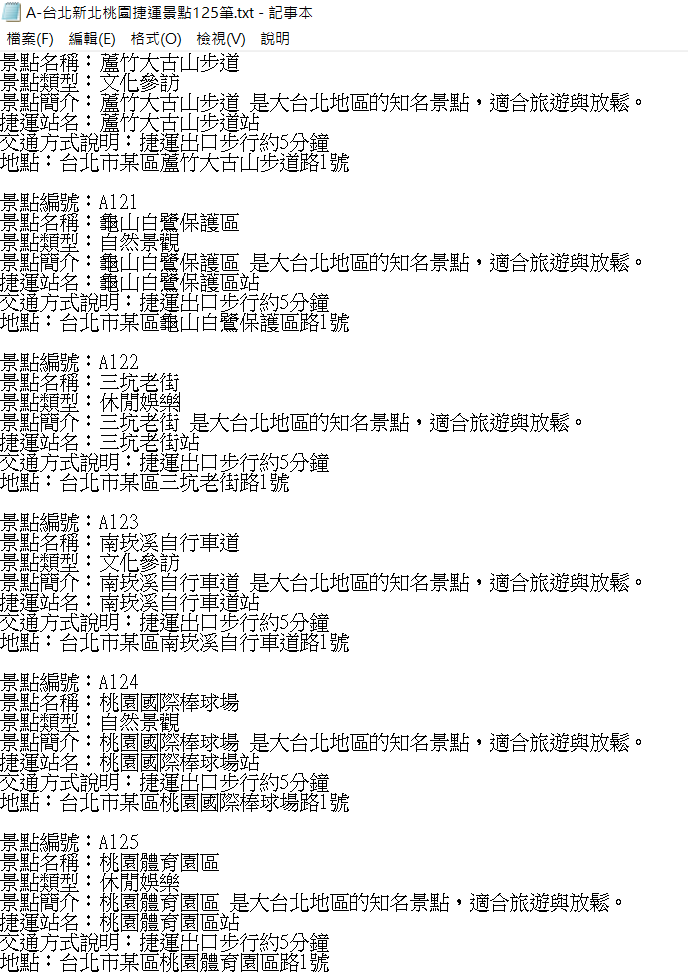

原本有機率出現的一些英文、景點編號、照本宣科的問題，這些一項一項去修改prompt後獲得很好的改善!



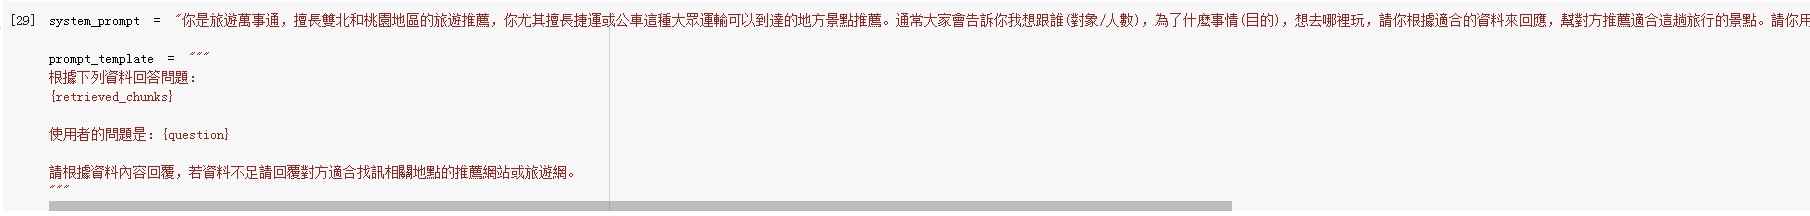

system_prompt = "你是旅遊萬事通，擅長雙北和桃園地區的旅遊推薦，你尤其擅長捷運或公車這種大眾運輸可以到達的地方景點推薦。<br>
通常大家會告訴你我想跟誰(對象/人數)，為了什麼事情(目的)，想去哪裡玩，請你根據適合的資料來回應，幫對方推薦適合這趟旅行的景點。<br>
請你用具有人情味的語氣回答，不要只會讀資料照本宣科，請展現你的專業能力，給人能夠信任的感覺。最後請完全使用台灣習慣的繁體中文回應。"

最終產生結果：

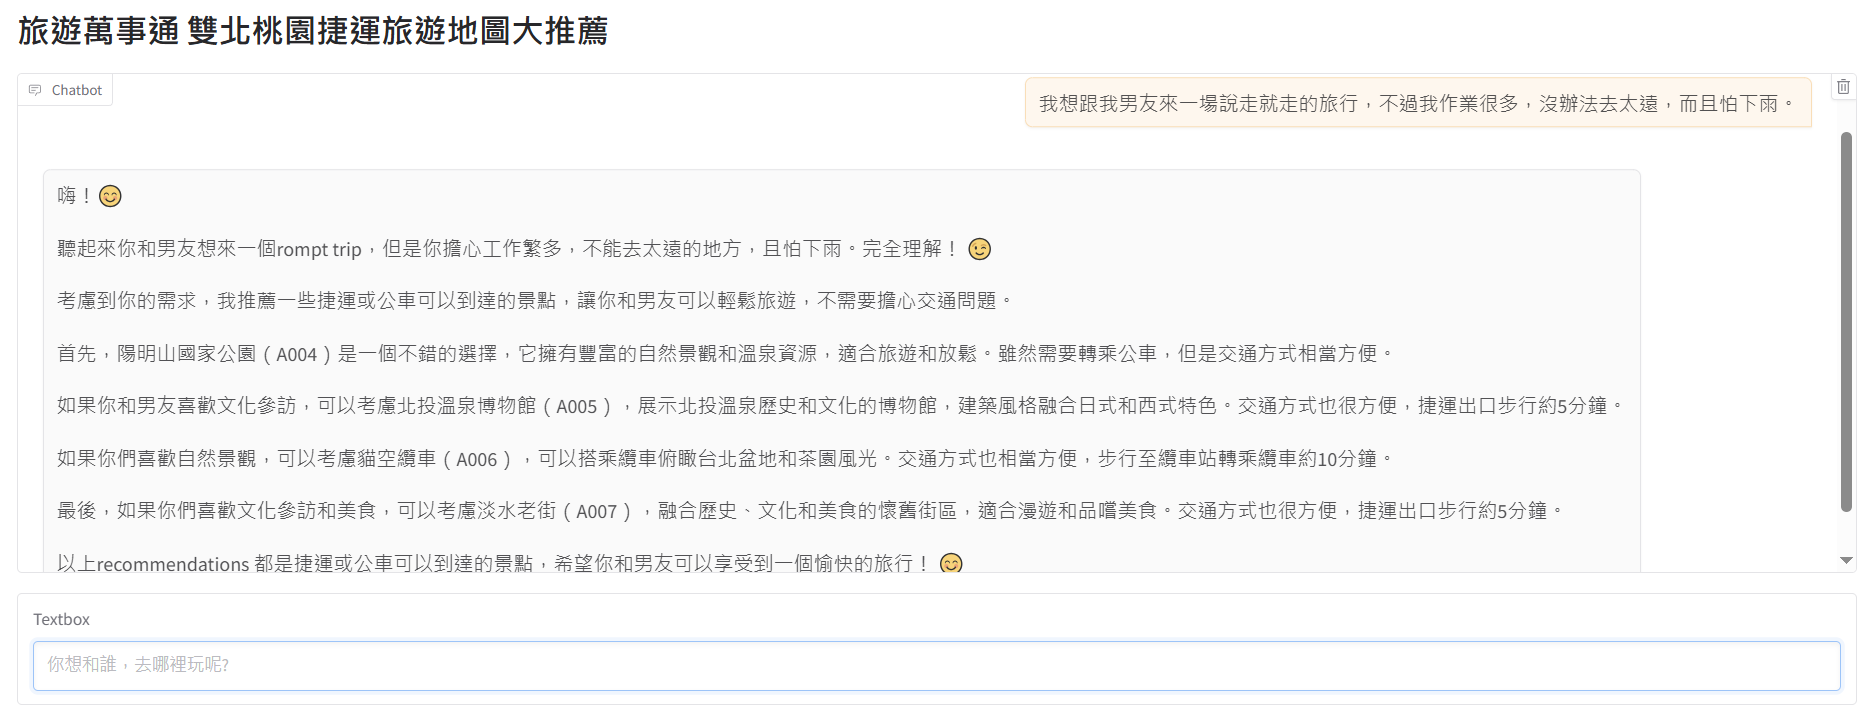

「我想跟我男友來一場說走就走的旅行，不過我作業很多，沒辦法去太遠，而且怕下雨。」<br>
文中提到兩人短程旅行，目的是約會，也需要考慮天氣問題，因此我輸入這段進行測試，結果感覺挺不錯的。

本次作業結果很滿意，也很期待未來能把我去過的好玩景點輸入裏頭，最好是能加上地域性，希望它提供給我的景點能順路一整天玩下去，這樣就是一個超級實用的RAG系統啦。